### Import lib.

In [354]:
import numpy as np
import os
import glob
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torchvision.models as models


### Import data

900


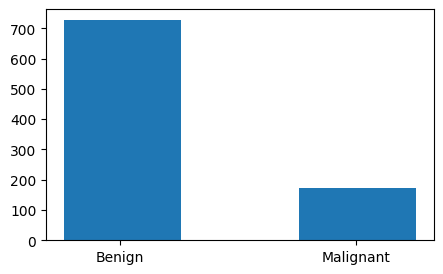

In [11]:

gt = np.genfromtxt("SkinLesionTraining_GroundTruth.csv", delimiter=",",dtype=str)  
gt = gt[:,1]
gt[np.where(gt=='benign')] = 0
gt[np.where(gt=='malignant')] = 1
gt = np.asarray(gt, dtype=float)


print(len(gt))
plt.figure(figsize=(5,3))
plt.hist(gt, 3)
plt.xticks((0.16,0.83), ('Benign', 'Malignant'))
plt.show()

In [3]:
# Put data separatly
IMAGE_ROOT_PATH = "/Users/caird/Documents/Cairui/Python1/Medical Image Analysis/Aflevering/Aflevering4/SkinLesionTrainingData/Image"
TRAIN_MASK_ROOT = "/Users/caird/Documents/Cairui/Python1/Medical Image Analysis/Aflevering/Aflevering4/SkinLesionTrainingData/Segmentation"

n_train_cases = len(os.listdir(f"{TRAIN_MASK_ROOT}"))
n_train_cases = len(os.listdir(f"{IMAGE_ROOT_PATH }"))
print(f"Found {n_train_cases} train cases")


train_mask = sorted(os.listdir(f"{TRAIN_MASK_ROOT}"))
train_image = sorted(os.listdir(f"{IMAGE_ROOT_PATH}"))



Found 900 train cases


## Preproces

In [4]:
x_size = []
y_size = []
for x in train_image:
    image = np.array(Image.open(f"{IMAGE_ROOT_PATH}/{x[:-3]}jpg").convert("L"))
    x_size.append(np.shape(image)[0])
    y_size.append(np.shape(image)[1])

1133.0655555555556 1555.9788888888888


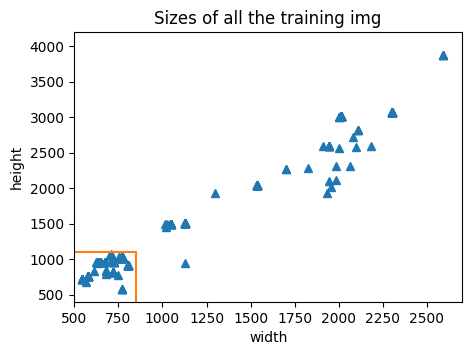

In [5]:
plt.figure(figsize=(5,3.5))
plt.plot(x_size, y_size, "^")
plt.plot((0, 850, 850), (1100, 1100, 0))
plt.title("Sizes of all the training img")
plt.xlim(500, 2700)
plt.ylim(400, 4200)
plt.xlabel("width")
plt.ylabel("height")
print(np.mean(x_size), np.mean(y_size))

Majority of images below 850 x 1100. So below this upscale, Above this downscale

In [6]:
w,h = 1000, 850

In [7]:
#mask_array_training = np.stack([get_joint_mask_as_array(x, TRAIN_MASK_ROOT, IMAGE_SHAPE) for x in train_masks], 0)
def get_image_as_array(image_name, mask_name, dsize=(w, h)):
    image = np.array(Image.open(f"{IMAGE_ROOT_PATH}/{image_name[:-3]}jpg").convert('RGB')) #'RGB'
    mask= np.array(Image.open(f"{TRAIN_MASK_ROOT}/{mask_name[:-3]}png").convert('RGB'))

    image[np.where(mask==0)]=0

    new_image = cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_CUBIC)
    return new_image


Stack all data

In [9]:
im_array = np.stack([get_image_as_array(x,y) for x,y in zip(train_image, train_mask)], 0)
print("Completed loading data")

Completed loading data


# Split daata

In [465]:


X_train, X_test, y_train, y_test = train_test_split(im_array, gt, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2) 


In [466]:
print(len(X_train), len(y_train))
print(len(X_test),  len(y_test))
print(len(X_val),  len(y_test))

540 540
180 180
180 180


In [467]:
print(np.shape(X_train), np.shape(im_array))

(540, 850, 1000, 3) (900, 850, 1000, 3)


### Get all the positive 

In [468]:
ground_truth_pos_index =  np.where(y_train==1)[0]
ground_truth_pos =y_train[ ground_truth_pos_index ]
print(len(ground_truth_pos ))



106


In [469]:
#Images with maglignent

im_array_training_pos = X_train[ground_truth_pos_index]

In [470]:
print(np.shape(im_array_training_pos))
print(np.shape(ground_truth_pos ))

(106, 850, 1000, 3)
(106,)


In [471]:
mu_1, mu_2, mu_3 = np.mean(X_train[:,:,:,0]), np.mean( X_train[:,:,:,1]), np.mean( X_train[:,:,:,2])
sig_1, sig_2, sig_3 = np.std( X_train[:,:,:,0]), np.std( X_train[:,:,:,1]), np.std( X_train[:,:,:,2])
print(mu_1, mu_2, mu_3)
print(sig_1, sig_2, sig_3 )


44.792801605664486 32.69763010457516 27.341957359477124
78.68376148665423 59.828521182721786 51.71989769787207


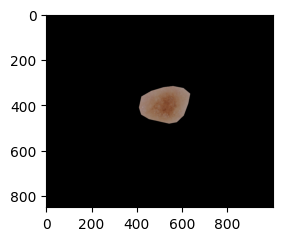

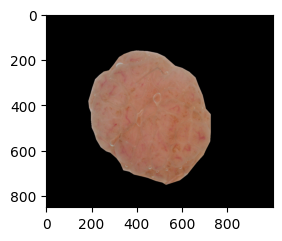

In [344]:
plt.figure(figsize=(4,2.5))
plt.imshow( X_train[0])
plt.show()
plt.figure(figsize=(4,2.5))
plt.imshow( X_train[1])
plt.show()


In [ ]:
#im_array_training = torch.from_numpy(im_array_training)
#ground_truth = torch.from_numpy(ground_truth)


# Augmentation

In [472]:
class SquarePad:
    def __call__(self, image):
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, hp, vp, vp)
        return F.pad(input=image, pad=padding, value=0)

In [474]:
transform_train_augmentation = transforms.Compose([
                    transforms.ToPILImage(mode='RGB'),#'RGB'
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=90),
                    transforms.GaussianBlur(kernel_size=5, sigma = (0.000001, 1.5)),
                    transforms.RandomAffine(degrees=90, translate=(0.2, 0.2), scale=(0.5, 1.5)), 
                    SquarePad(),
                    transforms.Resize(224),
                    transforms.Normalize(mean=[mu_1, mu_2, mu_3], std=[sig_1, sig_2, sig_3 ])
                    ])

#Below only rezises. Does not augment
transform_simple= transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    SquarePad(),
                    transforms.Resize(224),
                    transforms.Normalize(mean=[mu_1, mu_2, mu_3], std=[sig_1, sig_2, sig_3 ])
                    ])

In [475]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x
        
    def __len__(self):
        return len(self.subset)

In [476]:
#Augment train data 
train_data_augmentation = MyDataset( X_train , transform=transform_train_augmentation)

#Augment Positive labelled data
train_data_pos_augmentation1 = MyDataset(im_array_training_pos , transform=transform_train_augmentation)
train_data_pos_augmentation2 = MyDataset(im_array_training_pos , transform=transform_train_augmentation)
train_data_pos_augmentation3 = MyDataset(im_array_training_pos , transform=transform_train_augmentation)
train_data_pos_augmentation4 = MyDataset(im_array_training_pos , transform=transform_train_augmentation)
train_data_pos_augmentation5 = MyDataset(im_array_training_pos , transform=transform_train_augmentation)

#Transform the non-augmented data also to the same shape
train_data = MyDataset(X_train, transform=transform_simple)
val_data = MyDataset(X_val, transform=transform_simple)
test_data = MyDataset(X_test, transform=transform_simple) 


print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

print(np.shape(train_data_augmentation))
print(np.shape(train_data_pos_augmentation1))
print(np.shape(train_data_pos_augmentation2))
print(np.shape(train_data_pos_augmentation3))

(540, 3, 224, 224)
(180, 3, 224, 224)
(180, 3, 224, 224)
(540, 3, 224, 224)
(106, 3, 224, 224)
(106, 3, 224, 224)
(106, 3, 224, 224)


In [493]:
val_data = np.array(val_data)
test_data = np.array(test_data)

In [478]:
img_train = np.concatenate((np.array(train_data),  #non augmented train data
                          #np.array(train_data_augmentation), #Augmneted all train data
                          np.array(train_data_pos_augmentation1), #Augment positive once
                         np.array(train_data_pos_augmentation2), #Augment positive twice
                         np.array(train_data_pos_augmentation3)))
print(np.shape(img_train))

(858, 3, 224, 224)


In [479]:
ground_truth = np.concatenate((y_train, #non augmented
                                   #y_train, #Augmneted all
                                   ground_truth_pos, #Augment positive once
                                  ground_truth_pos,  #Augment positive twice
                                  ground_truth_pos))
np.shape(ground_truth)

(858,)

In [480]:
print("there are in tot ", len(np.where(ground_truth==0)[0]),  "Benign cases, and ", len(np.where(ground_truth==1)[0]), "Maglignent cases in the training data \n after augmentation")

there are in tot  434 Benign cases, and  424 Maglignent cases in the training data 
 after augmentation


# Shuffle data

In [481]:
img_new, ground_truth_new = shuffle(img_train, ground_truth, random_state=0) #Remove random_state if want different each time

In [482]:
print(np.shape(img_new))

(858, 3, 224, 224)


# Plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


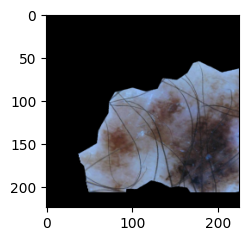

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


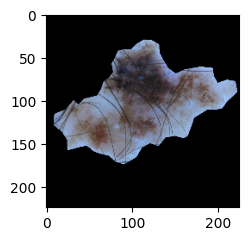

In [483]:
plt.figure(figsize=(4,2.5))
plt.imshow(np.moveaxis(np.array(train_data_pos_augmentation1[0,:,:]), 0, -1) * np.array([sig_1, sig_2, sig_3]) +  np.array([mu_1, mu_2, mu_3]))
plt.show()
plt.figure(figsize=(4,2.5))
plt.imshow(np.moveaxis(np.array(train_data[0,:,:]), 0, -1)* np.array([sig_1, sig_2, sig_3]) +  np.array([mu_1, mu_2, mu_3]))
plt.show()

# CNN: ResNet

### Version: fmassa 
https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [485]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [486]:
def get_acc(model_output, true_labels):
    predicted = torch.where(model_output < 0, 0, 1) #Get it on binary form
    correct = (predicted == true_labels).sum().item() #Number of correct predict
    acc = correct / len(true_labels) #Get it as percentage
    return acc

In [489]:


batch_size = 0
learning_rate = 0.001

#model = ResNet(ResidualBlock, [3, 4, 6, 3])
#model2 = MyResNet(models.resnet.BasicBlock, [2, 2, 2, 2])
model = resnet18()
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  



In [ ]:
data = torch.from_numpy(img_new) #torch.randn(10, 3, 224, 224) #
target = torch.from_numpy(ground_truth_new[:,None]) #torch.randint(0, 2, (10, 1)).float() #

loss_list = []
val_acc_list = []
train_acc_list=[]

num_epochs = 50
for epoch in range(num_epochs):
    # Move tensors to the configured device
    images = data
    labels = target

    # Forward pass
    outputs = model(images)
   

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    
    #Validation acc
    val_acc = get_acc(model_output = model(torch.from_numpy(val_data[:])),
                      true_labels = torch.from_numpy(y_val[:, None]))
   
    
    val_acc_list.append(val_acc)
    
    #Train acc
    train_acc = get_acc(model_output = outputs, true_labels = target)
    train_acc_list.append(train_acc)
    
    if epoch % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, loss.item()))
        #print(outputs,  "labels", labels)
        print("val acc", val_acc)
        print("train acc", train_acc)


Epoch [1/50], Loss: 1.9716
val acc 0.5611111111111111
train acc 0.5909090909090909
Epoch [11/50], Loss: 0.6393
val acc 0.6888888888888889
train acc 0.6561771561771562
Epoch [21/50], Loss: 0.5830
val acc 0.6833333333333333
train acc 0.6853146853146853
Epoch [31/50], Loss: 0.6464
val acc 0.7166666666666667
train acc 0.634032634032634


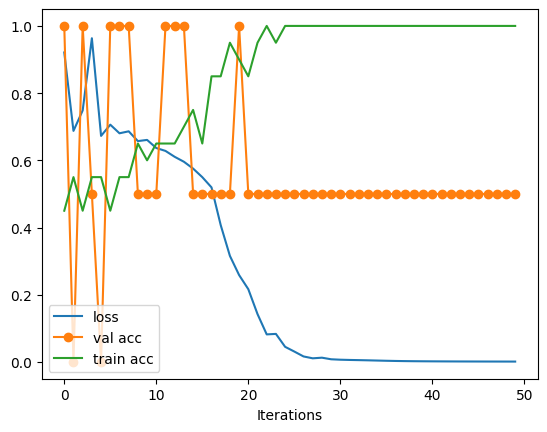

In [491]:
plt.plot(loss_list, label="loss")
plt.plot(val_acc_list, label="val acc", marker="o")
plt.plot(train_acc_list, label="train acc")
plt.xlabel("Iterations")
plt.legend()

# Save and load model

In [462]:
torch.save(model.state_dict(), 'model_weights.pth')



model = resnet18() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [142]:
np.shape(img_new[200])

(3, 224, 224)

# Eval

In [495]:
get_acc(model(torch.from_numpy(test_data)),  torch.from_numpy(y_test[:, None]))

0.5444444444444444

In [459]:
outputs = model(torch.from_numpy(img_new[0:10]))
print("out", outputs, outputs.data)

print("class", torch.max(outputs.data, 1)[0])

out tensor([[-31.6047],
        [-31.6009],
        [-31.6004],
        [-31.6249],
        [-31.6027],
        [-31.5994],
        [-31.6010],
        [-31.6057],
        [-31.6008],
        [-31.5980]], grad_fn=<AddmmBackward0>) tensor([[-31.6047],
        [-31.6009],
        [-31.6004],
        [-31.6249],
        [-31.6027],
        [-31.5994],
        [-31.6010],
        [-31.6057],
        [-31.6008],
        [-31.5980]])
class tensor([-31.6047, -31.6009, -31.6004, -31.6249, -31.6027, -31.5994, -31.6010,
        -31.6057, -31.6008, -31.5980])


In [391]:
print("correct class", torch.from_numpy(ground_truth_new[:10]) )

correct class tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 0.], dtype=torch.float64)


In [392]:
pred = torch.where(outputs < 0, 0, 1)
print(pred)
labels = torch.from_numpy(ground_truth_new[:10, None])
print(labels)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]], dtype=torch.float64)


In [431]:

correct = (pred== labels).sum().item()

RuntimeError: The size of tensor a (10) must match the size of tensor b (4) at non-singleton dimension 0

In [397]:
print(correct/ len(labels))

0.4
